In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.special as sc
from classy import Class
font = {'size'   : 22}
matplotlib.rc("font", **font)
matplotlib.rc(["text.usetex", True])

In [2]:
def TestFunction_Antiderivative(x, args):
    return -args[0]*(1 - sc.gammainc(4/5, x**2))/2 - 2*args[1]*np.cos(0.5*x)

def TestFunction(x, args):
    return args[0]*x**(3/5)/np.exp(x**2) + np.sin(0.5*x)*args[1]

def TestFunction(x, args):
    return 1/np.exp(1 + x)

In [3]:
u = 1.0 
s = 0.5
TestArgs = [u, s]
interval = [0.001, 25]

[Text(0.5, 0, 'x'), Text(0, 0.5, 'test function'), (0.001, 25.0)]

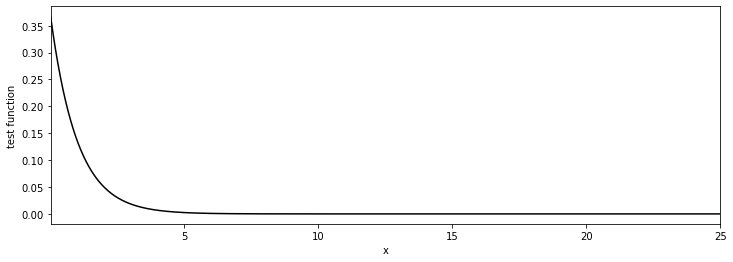

In [4]:
xlist = np.linspace(*interval, 10000)

fig, ax = plt.subplots(1, 1, figsize=[12, 4])
ax.plot(xlist, TestFunction(xlist, TestArgs), 'k-')
ax.set(xlabel='x', ylabel='test function', xlim=interval)

### Define integration methods

* Must integrate the input function on the interval $[a,b]$ using $N$ function evaluations

In [5]:
def Trapezoidal(func, interval, N, fargs):
    f_evals = N
    err = np.nan
    # Assume xlist evenly spaced
    # Trapez formally has N^2 convergence
    xlist = np.linspace(*interval, N)
    dx = xlist[1] - xlist[0]
    return dx*(0.5*func(xlist[0], fargs) + 0.5*func(xlist[-1], fargs) + np.sum(func(xlist[1:-1], fargs))), err, f_evals

def ExtendedSimpson(func, interval, N, fargs):
    f_evals = N
    err = np.nan
    # Assume xlist evenly spaced; only works like this with an even amount of points
    # Formally has N^4 convergence
    xlist = np.linspace(*interval, N)
    dx = xlist[1] - xlist[0]
    intg = 0
    intg += func(xlist[0], fargs)*1/3
    intg += func(xlist[-1], fargs)*1/3
    for idx, x in enumerate(xlist[1:-1]):
        if idx % 2 == 0:
            intg += 4/3*func(x, fargs)
        else:
            intg += 2/3*func(x, fargs)
    return dx*intg, err, f_evals

def GaussKronrod_quad(f, interval, is_indefinite, f_args):
    a, b = interval[0], interval[1]
    global f_evals
    f_evals += 15
    z_k = np.array([-0.991455371120813, -0.949107912342759, -0.864864423359769, -0.741531185599394, 
                    -0.586087235467691, -0.405845151377397, -0.207784955007898, 0.0,
                    0.207784955007898, 0.405845151377397, 0.586087235467691, 0.741531185599394,
                    0.864864423359769, 0.949107912342759, 0.991455371120813])
    w_k = np.array([0.022935322010529, 0.063092092629979, 0.104790010322250, 0.140653259715525,
                    0.169004726639267, 0.190350578064785, 0.204432940075298, 0.209482141084728,
                    0.204432940075298, 0.190350578064785, 0.169004726639267, 0.140653259715525,
                    0.104790010322250, 0.063092092629979, 0.022935322010529])
    w_g = np.array([0.129484966168870, 0.279705391489277, 0.381830050505119, 0.417959183673469,
                    0.381830050505119, 0.279705391489277, 0.129484966168870])
    
    # Transform z into t in interval between a and b:
    t = 0.5*(a*(1 - z_k) + b*(1 + z_k))
    # Modify weights such that it reflects the linear transformation above: */
    w_k *= 0.5*(b - a)
    w_g *= 0.5*(b - a)
    if is_indefinite:
        # Transform t into x in interval between 0 and inf:
        x = 1.0/t - 1.0
        # Modify weight accordingly:
        w_k /= (t*t)
        w_g /= (t[1::2]*t[1::2])
    else:
        x = t
    
    y = np.array([f(xx, f_args) for xx in x])
    
    Ik = np.dot(y, w_k)
    Ig = np.dot(y[1::2], w_g)
    err = (200*abs(Ik - Ig))**1.5
    return Ik, err

def GaussKronrod_adapt(f, interval, rtol, is_indefinite=False, f_args=[]):
    a, b = interval[0], interval[1]
    # Do adaptive Gauss-Kronrod quadrature.
    # To integrate between 0 and infinity, set a=0, b=1 and is_indefinite=True on first call
    I, err = GaussKronrod_quad(f, interval, is_indefinite, f_args)
    # Stop recursion if tolerance has been made or recursion is too deep:
    if err/I < rtol or rtol > 1:
        return I, err
    else:
        m = 0.5*(a + b)
        I_left, err_left = GaussKronrod_adapt(f, [a, m], 1.5*rtol, is_indefinite, f_args)
        I_rght, err_rght = GaussKronrod_adapt(f, [m, b], 1.5*rtol, is_indefinite, f_args)
        return I_left + I_rght, np.sqrt(err_left**2 + err_rght**2)

### Plot comparisons

In [6]:
Nlist = [2, 10, 100, 500, 1000]
int_trapz = []
int_simps = []

func = TestFunction

rtol_exact = 1e-10

#int_exact = TestFunction_Antiderivative(interval[1], TestArgs) - TestFunction_Antiderivative(interval[0], TestArgs)
int_exact, exact_error, scipy_info = quad(TestFunction, *interval, args=(TestArgs), full_output=1, epsrel=rtol_exact)
print(f"Integral is {int_exact} with absolute error {exact_error} after {scipy_info['neval']} function evaluations from scipy.quad.")
int_exact = 1/np.exp(1)

f_evals = 0
int_gk, err_gk = GaussKronrod_adapt(TestFunction, interval, rtol_exact, f_args=TestArgs)
print(f"Integral is {int_gk} with absolute error {err_gk} after {f_evals} function evaluations with GK.")

for N in Nlist:
    int_trapz.append(Trapezoidal(func, interval, N, TestArgs))
    int_simps.append(ExtendedSimpson(func, interval, N, TestArgs))
    
rtol_list = [1e-0, 1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16, 1e-18]
int_gk    = []
gk_evals = []
for rtol in rtol_list:
    f_evals = 0
#    inte, err_gk = GaussKronrod_adapt(TestFunction, interval, rtol, f_args=TestArgs)
    inte, err_gk = GaussKronrod_adapt(TestFunction, [0, 1], rtol, is_indefinite=True, f_args=TestArgs)
    int_gk.append(inte)
    gk_evals.append(f_evals)

Integral is 0.36751174560358474 with absolute error 2.199061379854931e-12 after 63 function evaluations from scipy.quad.
Integral is 0.36751174560358335 with absolute error 8.251229973786643e-15 after 135 function evaluations with GK.


/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_43431/1896619077.py:8: RuntimeWarning: overflow encountered in exp
  return 1/np.exp(1 + x)


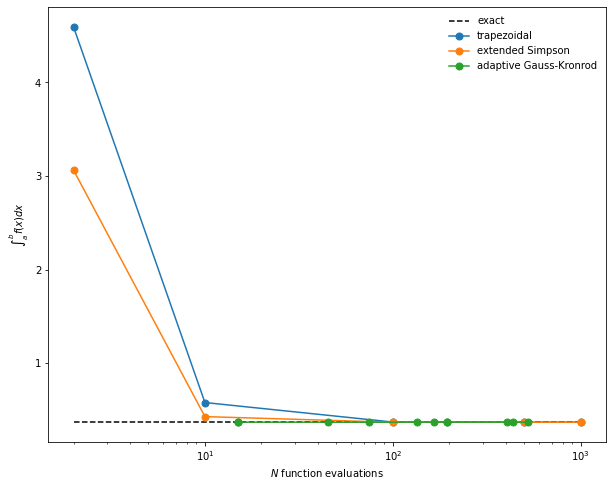

In [7]:
# Convergence plot
plt.figure(figsize=[10,8])
#plt.xlabel('$N$ integration points')
plt.xlabel('$N$ function evaluations')
plt.plot(Nlist, np.ones(len(Nlist))*int_exact, 'k--', label='exact')
plt.plot(Nlist, [int_trapz[i][0] for i in range(len(Nlist))], '.-', label='trapezoidal', ms=14)
plt.plot(Nlist, [int_simps[i][0] for i in range(len(Nlist))], '.-', label='extended Simpson', ms=14)
plt.plot(gk_evals, int_gk, '.-', label='adaptive Gauss-Kronrod', ms=14)
plt.xscale('log');
plt.ylabel('$\int_a^b f(x) dx$')
plt.legend(frameon=False)

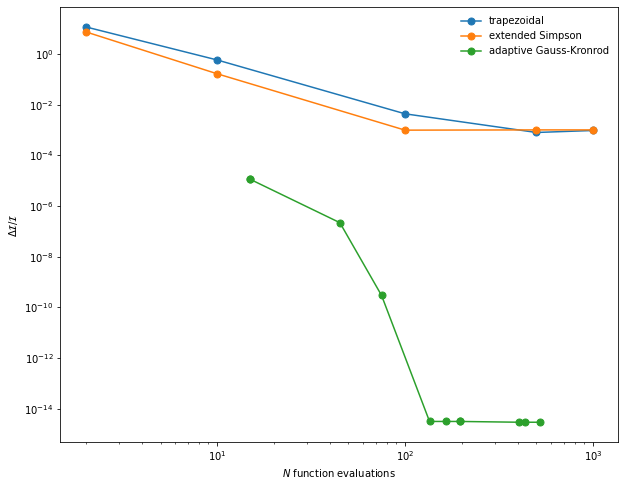

In [8]:
# Convergence plot
plt.figure(figsize=[10,8])
#plt.xlabel('$N$ integration points')
plt.xlabel('$N$ function evaluations')
plt.plot(Nlist, np.abs(np.array([int_trapz[i][0] for i in range(len(Nlist))])/int_exact - 1), '.-', label='trapezoidal', ms=14)
plt.plot(Nlist, np.abs(np.array([int_simps[i][0] for i in range(len(Nlist))])/int_exact - 1), '.-', label='extended Simpson', ms=14)
plt.plot(gk_evals, np.abs(np.array(int_gk)/int_exact - 1), '.-', label='adaptive Gauss-Kronrod', ms=14)
plt.xscale('log'); plt.yscale('log')
plt.ylabel('$\Delta \mathcal{I}/\mathcal{I}$')
plt.legend(frameon=False)